Import the necessary libraries to perform actions


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Model

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


import the dataset from keggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 98% 279M/285M [00:02<00:00, 101MB/s] 
100% 285M/285M [00:02<00:00, 112MB/s]


In [ ]:
!unzip /content/challenges-in-representation-learning-facial-expression-recognition-challenge.zip

Archive:  /content/challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
train = pd.read_csv('/content/train.csv')
print(train.shape)

(28709, 2)


look in to values in test data

In [ ]:
train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


# Preprocess Data

images for this training dataset are stored as string. In order to train the model and visualize the imageswe need to process these strings in to a 4D array of pixel values

In [ ]:
train['pixels'] = [np.fromstring(x, dtype=int, sep=' ').reshape(-1,48,48) for x in train['pixels']]

In [ ]:
pixels = np.concatenate(train['pixels'])
labels = train.emotion.values

print(pixels.shape)
print(labels.shape)

(28709, 48, 48)
(28709,)


# Label Distribution

distribution of labels are as below

In [ ]:
emotion_prop = (train.emotion.value_counts() / len(train)).to_frame().sort_index(ascending=True)

emotion_prop

,emotion
0,0.139155
1,0.015187
2,0.142708
3,0.251315
4,0.168240
5,0.110453
6,0.172942


In [ ]:
emotions = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

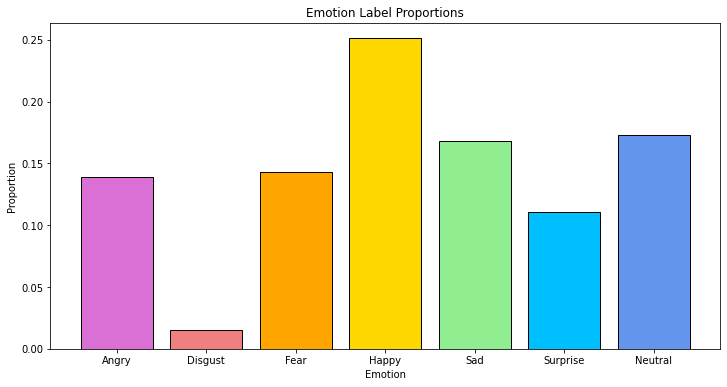

In [ ]:
palette = ['orchid', 'lightcoral', 'orange', 'gold', 'lightgreen', 'deepskyblue', 'cornflowerblue']

plt.figure(figsize=[12,6])

plt.bar(x=emotions, height=emotion_prop['emotion'], color=palette, edgecolor='black')
    
plt.xlabel('Emotion')
plt.ylabel('Proportion')
plt.title('Emotion Label Proportions')
plt.show()

As we can see from the distribution of labels, there is a class imbalance within this training set: the emotion happy accounts for about 25% of the data.

# View Sample of Image

view a sample of images for each eotions labeled

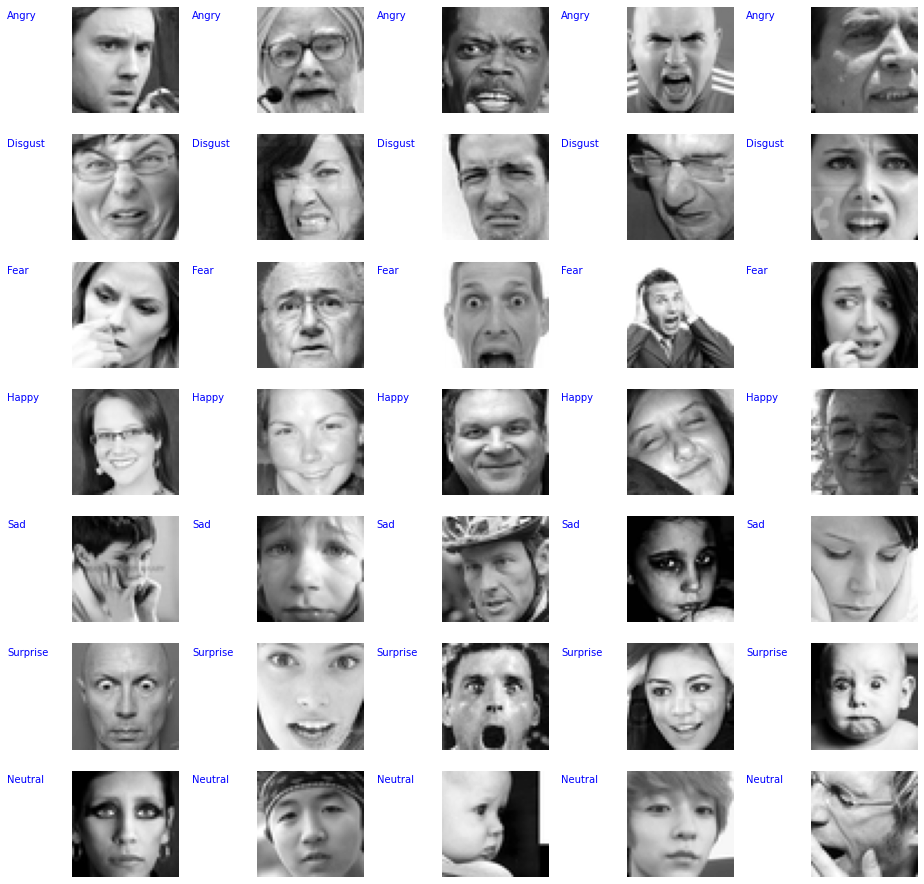

In [ ]:
plt.close()
plt.rcParams["figure.figsize"] = [16,16]

row = 0
for emotion in np.unique(labels):

    all_emotion_images = train[train['emotion'] == emotion]
    for i in range(5):
        
        img = all_emotion_images.iloc[i,].pixels.reshape(48,48)
        lab = emotions[emotion]

        plt.subplot(7,5,row+i+1)
        plt.imshow(img, cmap='binary_r')
        plt.text(-30, 5, s = str(lab), fontsize=10, color='b')
        plt.axis('off')
    row += 5

plt.show()

# Split, Reshape, ScaleDatasets

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    pixels, labels, test_size=0.2, stratify=labels, random_state=1
)


print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print()
print('X_valid Shape:', X_valid.shape)
print('y_valid Shape:', y_valid.shape)

X_train Shape: (22967, 48, 48)
y_train Shape: (22967,)

X_valid Shape: (5742, 48, 48)
y_valid Shape: (5742,)


ResNet50 was trained with RGB images, and our data is in grayscale. In order to use the pretrained weights of the ResNet50 model we need to convert the single grayscale channel of our images into 3 channels (RGB).

In [ ]:
rgb_X_train = np.repeat(X_train[..., np.newaxis], 3, -1)
print(rgb_X_train.shape)

rgb_X_valid = np.repeat(X_valid[..., np.newaxis], 3, -1)
print(rgb_X_valid.shape)

(22967, 48, 48, 3)
(5742, 48, 48, 3)


# Image Augmentation

to prevent overlifting, we use image augmentation to create additional training observations

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.3, 
    height_shift_range = 0.3, 
    zoom_range = 0.3, 
    horizontal_flip = True, 
    fill_mode = 'reflect'
)

train_loader = train_datagen.flow(rgb_X_train, y_train, batch_size=64)

Transfer learning with ResNet50 model

In [ ]:
resnet_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False, weights='imagenet', input_shape=(48,48,3))

resnet_model.trainable = False

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

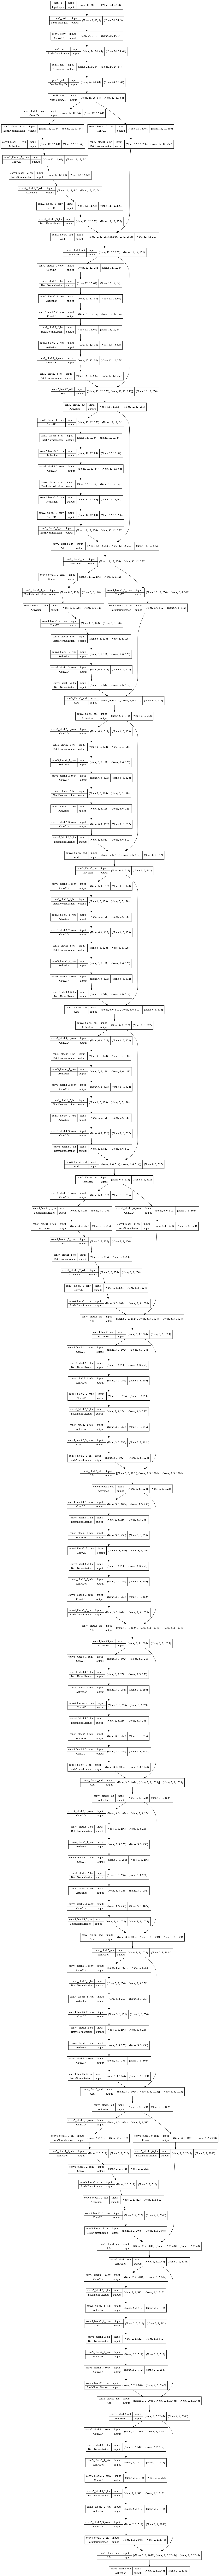

In [ ]:
tf.keras.utils.plot_model(resnet_model, show_shapes=True)

# Configure Model

add density-connected layers, incoporating dropout and batch normalization

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

cnn = Sequential([
    resnet_model,
    BatchNormalization(),

    Flatten(),
    
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.7),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.7),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(7, activation='softmax')
])

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 batch_normalization (BatchN  (None, 2, 2, 2048)       8192      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 512)               0

# Train Model

Train model using Adam optimizer , a learning rate of 0.0001, and sparse categorical crossentropy loss

In [ ]:
opt = tf.keras.optimizers.Adam(0.0001)
cnn.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

epochs = 30

Lets pass a callback on to the odel so it saves modelweights

In [ ]:
%%time 

h1 = cnn.fit(
    train_loader, 
    batch_size=32,
    epochs = 30,
    verbose = 1,
    validation_data = (rgb_X_valid, y_valid)
)

Epoch 1/30
359/359 [==============================] - 291s 797ms/step - loss: 2.9136 - accuracy: 0.1592 - val_loss: 1.8498 - val_accuracy: 0.2992
Epoch 2/30
359/359 [==============================] - 284s 792ms/step - loss: 2.6050 - accuracy: 0.1910 - val_loss: 1.7939 - val_accuracy: 0.3255
Epoch 3/30
359/359 [==============================] - 285s 795ms/step - loss: 2.4198 - accuracy: 0.2015 - val_loss: 1.7532 - val_accuracy: 0.3311
Epoch 4/30
359/359 [==============================] - 287s 800ms/step - loss: 2.2924 - accuracy: 0.2084 - val_loss: 1.7452 - val_accuracy: 0.3297
Epoch 5/30
359/359 [==============================] - 286s 797ms/step - loss: 2.1710 - accuracy: 0.2229 - val_loss: 1.7328 - val_accuracy: 0.3352
Epoch 6/30
359/359 [==============================] - 286s 798ms/step - loss: 2.1093 - accuracy: 0.2297 - val_loss: 1.7113 - val_accuracy: 0.3363
Epoch 7/30
359/359 [==============================] - 315s 877ms/step - loss: 2.0518 - accuracy: 0.2333 - val_loss: 1.7037 -

In [ ]:
#save model
cnn.save("my_model2.hdf5")

In [ ]:
cnn.save_weights("my-weights")

In [ ]:
history = h1.history
print(history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


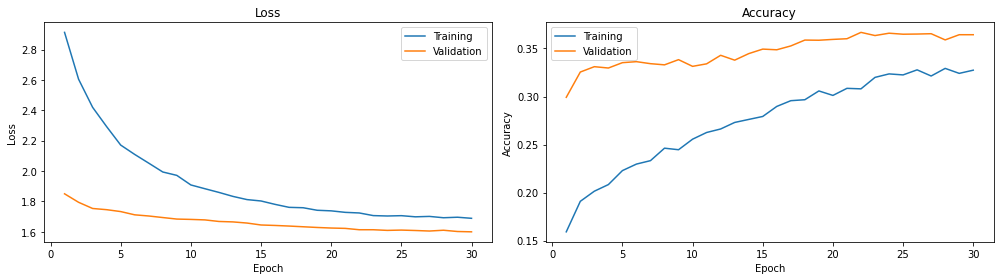

In [ ]:
epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

From the learning curves we can see there is slight overfitting, and the model could benefit from additional epochs.